In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm  # tqdm is used for displaying progress bars
import glob
import tensorflow  # Import the TensorFlow library

from tqdm import tqdm  # Import tqdm again, this seems to be redundant
from sklearn.utils import shuffle  # Import the shuffle function from scikit-learn
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting the data

from skimage.io import imread, imshow  # Import functions for reading and displaying images from scikit-image
from skimage.transform import resize  # Import resize function from scikit-image
from skimage.color import gray2rgb  # Import gray2rgb function from scikit-image

# Import necessary modules from TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169  # Import the DenseNet169 model from TensorFlow
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Import functions for loading and converting images


In [ ]:
# Data Augmentation for Training Dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to the range [0, 1]
    rotation_range=30,  # Randomly rotate images by up to 30 degrees
    zoom_range=0.2,  # Randomly zoom into images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    validation_split=0.2  # Fraction of the training data to be used as validation data
)

# Data Augmentation for Validation Dataset
valid_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to the range [0, 1]
    validation_split=0.2  # Fraction of the training data to be used as validation data
)

# Data Augmentation for Test Dataset
test_datagen = ImageDataGenerator(
    rescale=1./255  # Rescale pixel values to the range [0, 1]
)


In [ ]:
# Generate Training Dataset using Data Augmentation
train_dataset = train_datagen.flow_from_directory(
    directory='C:\\Users\\K M SASTRY\\Desktop\\Alzheimer_s Dataset\\train',  # Path to the directory containing training images
    target_size=(224, 224),  # Resize images to the specified dimensions
    class_mode='categorical',  # Use categorical labels (one-hot encoded) for multiclass classification
    subset='training',  # Specify that this is the training subset of the dataset
    batch_size=128  # Number of images to include in each batch during training
)


Found 4098 images belonging to 4 classes.


In [ ]:
# Generate Validation Dataset
valid_dataset = valid_datagen.flow_from_directory(
    directory='C:\\Users\\K M SASTRY\\Desktop\\Alzheimer_s Dataset\\test',  # Path to the directory containing validation images
    target_size=(224, 224),  # Resize images to the specified dimensions
    class_mode='categorical',  # Use categorical labels (one-hot encoded) for multiclass classification
    subset='validation',  # Specify that this is the validation subset of the dataset
    batch_size=128  # Number of images to include in each batch during validation
)


Found 254 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:43<00:00, 20.75s/it]


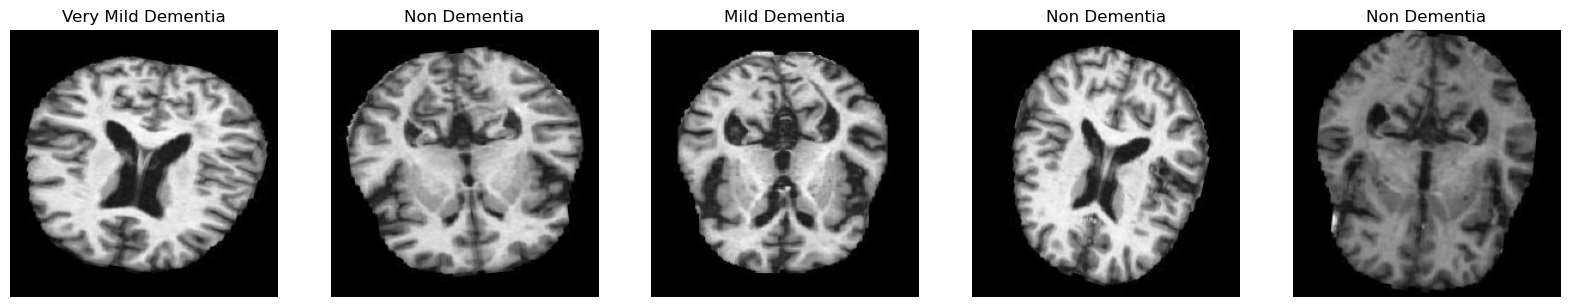

In [ ]:
# Display Random Images from Different Classes in the Training Dataset
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

# Loop to display 5 random images with their corresponding class labels
for i in tqdm(range(0, 5)):
    # Generate random indices
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)

    # Display the image
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')

    # Get the one-hot encoded label
    a = train_dataset[rand1][1][rand2]

    # Set title based on the class label
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm  # tqdm is used for displaying progress bars
import glob
import tensorflow  # Import the TensorFlow library

from tqdm import tqdm
from sklearn.utils import shuffle  # Import the shuffle function from scikit-learn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow  # Import functions for reading and displaying images from scikit-image
from skimage.transform import resize  # Import resize function from scikit-image
from skimage.color import gray2rgb  # Import gray2rgb function from scikit-image

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

# Import additional components from Keras
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import keras.backend as K

# Import TensorFlow Addons
import tensorflow_addons as tfa
from tensorflow.keras.metrics import Metric
from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Model Initialization using ResNet50 as Base Model

# ResNet50 is a pre-trained convolutional neural network architecture
# It is initialized with pre-trained weights on the ImageNet dataset
base_model = ResNet50(input_shape=(224, 224, 3),  # Input shape for the images
                      include_top=False,  # Exclude the fully-connected layers at the top
                      weights="imagenet")  # Use pre-trained weights from ImageNet


In [ ]:
# Freezing Layers in the Base Model

# Loop through each layer in the base model
for layer in base_model.layers:
    # Set each layer as non-trainable (freeze the weights)
    layer.trainable = False


In [ ]:
# Building a Custom Model with Adjusted Parameters

# Create a Sequential model
model = Sequential()

# Add the pre-trained ResNet50 as the base model
model.add(base_model)

# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Flatten the output from the base model
model.add(Flatten())

# Apply Batch Normalization to normalize the activations
model.add(BatchNormalization())

# Add a fully connected layer with 2048 neurons and 'he_uniform' kernel initializer
model.add(Dense(2048, kernel_initializer='he_uniform'))

# Apply Batch Normalization
model.add(BatchNormalization())

# Apply ReLU activation function
model.add(Activation('relu'))

# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add another fully connected layer with 1024 neurons and 'he_uniform' kernel initializer
model.add(Dense(1024, kernel_initializer='he_uniform'))

# Apply Batch Normalization
model.add(BatchNormalization())

# Apply ReLU activation function
model.add(Activation('relu'))

# Add another Dropout layer
model.add(Dropout(0.5))

# Add the final output layer with 4 neurons (for 4 classes) and softmax activation
model.add(Dense(4, activation='softmax'))


In [ ]:
# Display Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              205522944 
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                       

In [ ]:
# Model Compilation

# Choose the Adam optimizer with a learning rate of 0.001
OPT = tf.keras.optimizers.Adam(lr=0.001)

# Compile the model with categorical crossentropy loss, AUC as a metric, and the chosen optimizer
model.compile(loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')],
              optimizer=OPT)


In [ ]:
# Defining Callbacks

# Specify the file path to save the best weights
filepath = './best_weights.hdf5'

# EarlyStopping callback monitors validation AUC, stops training if no improvement after 15 epochs
earlystopping = EarlyStopping(monitor='val_auc',
                              mode='max',
                              patience=15,
                              verbose=1)

# ModelCheckpoint callback saves the best weights based on validation AUC
checkpoint = ModelCheckpoint(filepath,
                              monitor='val_auc',
                              mode='max',
                              save_best_only=True,
                              verbose=1)

# Create a list of callbacks to be used during training
callback_list = [earlystopping, checkpoint]


In [ ]:
# Training the Model

# Use the fit method to train the model on the training dataset, validate on the validation dataset
model_history = model.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=20,  # Number of epochs for training (can be adjusted)
                          callbacks=callback_list,  # Use defined callbacks during training
                          verbose=1)


Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 1.4520 - auc: 0.7500 
Epoch 1: val_auc improved from -inf to 0.75455, saving model to .\best_weights.hdf5


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 862s 25s/step - loss: 1.4520 - auc: 0.7500 - val_loss: 1.1559 - val_auc: 0.7545
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 1.2073 - auc: 0.7905 
Epoch 2: val_auc improved from 0.75455 to 0.79566, saving model to .\best_weights.hdf5
33/33 [==============================] - 840s 25s/step - loss: 1.2073 - auc: 0.7905 - val_loss: 1.1006 - val_auc: 0.7957
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 1.1428 - auc: 0.7976 
Epoch 3: val_auc improved from 0.79566 to 0.80566, saving model to .\best_weights.hdf5
33/33 [==============================] - 798s 24s/step - loss: 1.1428 - auc: 0.7976 - val_loss: 0.9897 - val_auc: 0.8057
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 1.0780 - auc: 0.8048 
Epoch 4: val_auc improved from 0.80566 to 0.82417, saving model to .\best_weights.hdf5
33/33 [==============================] - 809s 24s/step - loss: 1.0780 - auc: 0.8048 - val_loss: 0.9481 - v

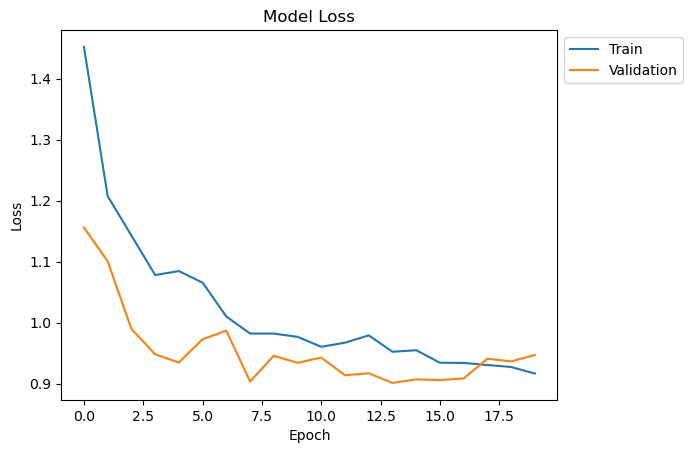

In [ ]:
# Plotting Model Loss Over Epochs

# Plot the training and validation loss over epochs
plt.plot(model_history.history['loss'], label='Train')  # Training loss curve
plt.plot(model_history.history['val_loss'], label='Validation')  # Validation loss curve
plt.title('Model Loss')  # Set the plot title
plt.ylabel('Loss')  # Label for the y-axis
plt.xlabel('Epoch')  # Label for the x-axis
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend to the upper left corner
plt.show()  # Display the plot


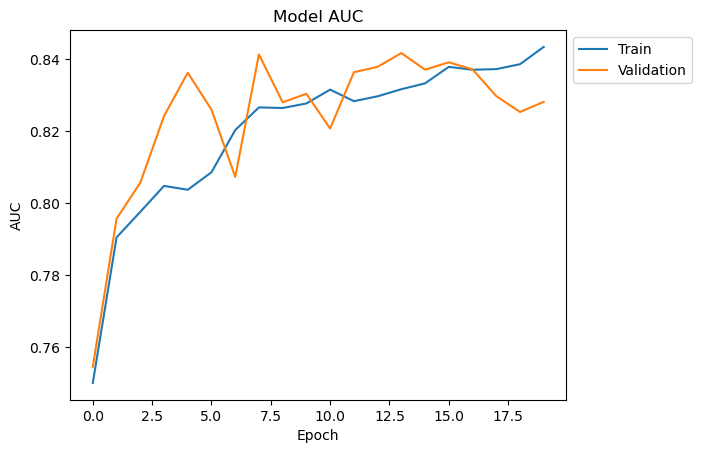

In [ ]:
# Plotting Model AUC Over Epochs

# Plot the training and validation AUC over epochs
plt.plot(model_history.history['auc'], label='Train')  # Training AUC curve
plt.plot(model_history.history['val_auc'], label='Validation')  # Validation AUC curve
plt.title('Model AUC')  # Set the plot title
plt.ylabel('AUC')  # Label for the y-axis
plt.xlabel('Epoch')  # Label for the x-axis
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend to the upper left corner
plt.show()  # Display the plot


In [ ]:
# Test Dataset Configuration

# Specify the directory for the test dataset using double backslashes for proper escaping
test_directory = "C:\\Users\\K M SASTRY\\Desktop\\Alzheimer_s Dataset\\test"

# Configure the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0,1]

# Create a flow from the test directory
test_dataset = test_datagen.flow_from_directory(directory=test_directory,
                                                target_size=(224, 224),
                                                class_mode='categorical',
                                                batch_size=128)


Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluating Model on Test Dataset

# Use the evaluate method to assess model performance on the test dataset
evaluation_results = model.evaluate(test_dataset)

# The evaluation_results may include metrics such as loss and AUC
# Print or use the results as needed for further analysis or reporting
print("Test Loss:", evaluation_results[0])
print("Test AUC:", evaluation_results[1])


10/10 [==============================] - 97s 10s/step - loss: 1.0287 - auc: 0.8026
Test Loss: 1.028655767440796
Test AUC: 0.8026286363601685


1/1 [==============================] - 0s 185ms/step
70.02 % chances are there that the image is Non-Dementia


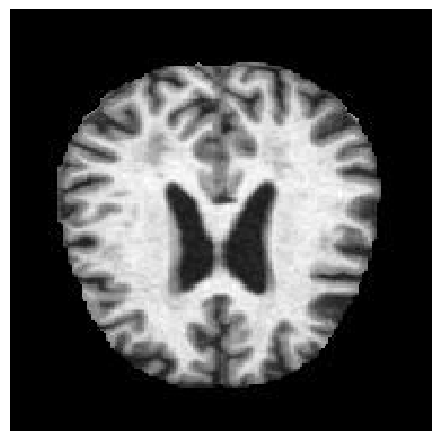

In [ ]:
# Test Case No.1: Non-Dementia

# Get class indices and create a dictionary for label mapping
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

# Import the missing functions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load an image from the test dataset for Non-Dementia
img = load_img("C:\\Users\\K M SASTRY\\Desktop\Alzheimer_s Dataset\\test\\NonDemented\\29 (80).jpg", target_size=(224, 224, 3))
img = img_to_array(img)
img = img/255  # Normalize pixel values to [0, 1]
imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)  # Expand dimensions to match the model input shape

# Predict the class using the trained model
# answer = model.predict_classes(img)
answer = (model.predict(img) > 0.5).astype("int32")
# probability = round(np.max(model.predict_proba(img)*100), 2)
probability = round(np.max(model.predict(img) * 100), 2)

# Print the probability and prediction for Non-Dementia
print(probability, '% chances are there that the image is Non-Dementia')


1/1 [==============================] - 0s 192ms/step
80.9800033569336% chances are there that the image is Mild Demented


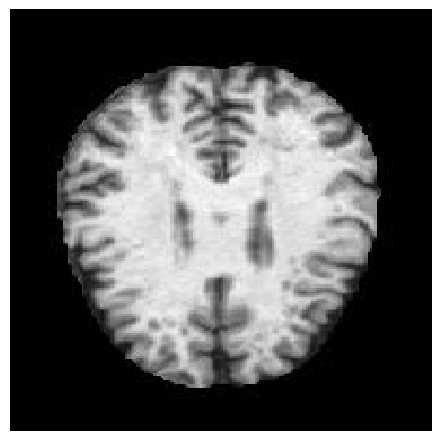

In [ ]:
# Test Case 2: Mild Demented

# Get class indices and create a dictionary for label mapping
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

# Load an image from the test dataset for Mild Demented
img_path = "C:\\Users\\K M SASTRY\\Desktop\\Alzheimer_s Dataset\\test\\MildDemented\\31 (18).jpg"
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

# Display the image
imshow(img_array)
plt.axis('off')

# Expand dimensions to match the model input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = (model.predict(img_array) > 0.5).astype("int32")

# Calculate the probability for Mild Demented
probability = round(np.max(model.predict(img_array) * 100), 2)

# Print the probability and prediction for Mild Demented
print(f"{probability}% chances are there that the image is Mild Demented")


1/1 [==============================] - 0s 182ms/step
65.73999786376953% chances are there that the image is Moderate Demented


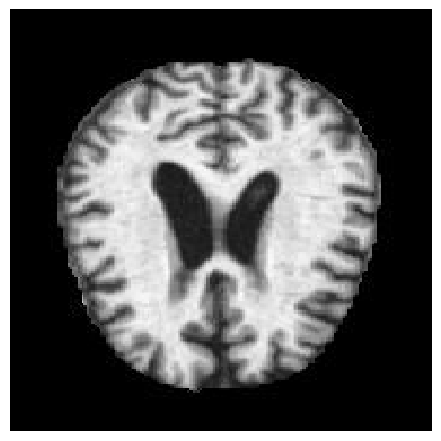

In [ ]:
# Test Case 3: Moderate Demented

# Get class indices and create a dictionary for label mapping
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

# Load an image from the test dataset for Moderate Demented
img_path = "C:\\Users\\K M SASTRY\\Desktop\\Alzheimer_s Dataset\\test\\ModerateDemented\\27.jpg"
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

# Display the image
imshow(img_array)
plt.axis('off')

# Expand dimensions to match the model input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = (model.predict(img_array) > 0.5).astype("int32")

# Calculate the probability for Moderate Demented
probability = round(np.max(model.predict(img_array) * 100), 2)

# Print the probability and prediction for Moderate Demented
print(f"{probability}% chances are there that the image is Moderate Demented")


1/1 [==============================] - 0s 191ms/step
73.95999908447266% chances are there that the image is Very Mild Demented


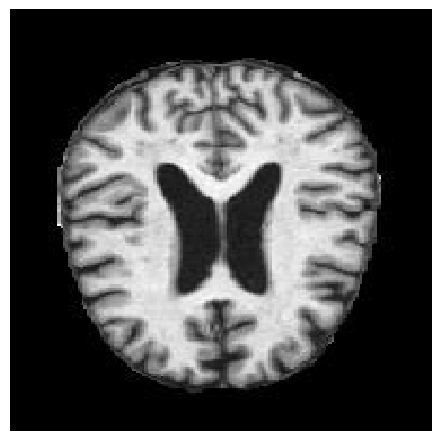

In [ ]:
# Test Case 4: Very Mild Demented

# Get class indices and create a dictionary for label mapping
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

# Load an image from the test dataset for Very Mild Demented
img_path = "C:\\Users\\K M SASTRY\\Desktop\\Alzheimer_s Dataset\\test\\VeryMildDemented\\26 (44).jpg"
img = load_img(img_path, target_size=(224, 224, 3))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

# Display the image
imshow(img_array)
plt.axis('off')

# Expand dimensions to match the model input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict the class using the trained model
prediction = (model.predict(img_array) > 0.5).astype("int32")

# Calculate the probability for Very Mild Demented
probability = round(np.max(model.predict(img_array) * 100), 2)

# Print the probability and prediction for Very Mild Demented
print(f"{probability}% chances are there that the image is Very Mild Demented")


In [ ]:
# Extract AUC values from the model history and convert to percentages
train_auc_percent = model_history.history['auc'][-1] * 100
val_auc_percent = model_history.history['val_auc'][-1] * 100

# Print the AUC percentages for training and validation
print(f"Train AUC: {train_auc_percent:.2f}%")
print(f"Validation AUC: {val_auc_percent:.2f}%")


Train AUC: 84.34%
Validation AUC: 82.81%
